# **Initial setup**

In [ ]:
!pip install xgboost

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/fz-fyp-new/cleaned_wind_data.csv', parse_dates=['Date/Time'])
data.sort_values(by='Date/Time', inplace=True)  # Ensure the data is in chronological order
data.reset_index(drop=True, inplace=True)


In [ ]:
print(data.head())
print(data.info())


            Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0 2018-01-01 00:00:00           380.047791          5.311336   
1 2018-01-01 00:10:00           453.769196          5.672167   
2 2018-01-01 00:20:00           306.376587          5.216037   
3 2018-01-01 00:30:00           419.645905          5.659674   
4 2018-01-01 00:40:00           380.650696          5.577941   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  Hour  Month  
0                     416.328908          259.994904     0      1  
1                     519.917511          268.641113     0      1  
2                     390.900016          272.564789     0      1  
3                     516.127569          271.258087     0      1  
4                     491.702972          265.674286     0      1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                     

In [ ]:
print(data.isnull().sum())


Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
Hour                             0
Month                            0
dtype: int64


In [ ]:
print(data.describe())


                           Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
count                          50530         50530.000000      50530.000000   
mean   2018-07-01 20:01:30.065307648          1307.684699          7.557952   
min              2018-01-01 00:00:00             0.000000          0.000000   
25%              2018-04-03 05:22:30            50.677890          4.201395   
50%              2018-06-30 16:15:00           825.838074          7.104594   
75%              2018-09-26 18:57:30          2482.507568         10.300020   
max              2018-12-31 23:50:00          3618.732910         25.206011   
std                              NaN          1312.458876          4.227166   

       Theoretical_Power_Curve (KWh)  Wind Direction (°)          Hour  \
count                   50530.000000        50530.000000  50530.000000   
mean                     1492.175463          123.687559     11.517356   
min                         0.000000            0.000000      0.00

## **EDA**

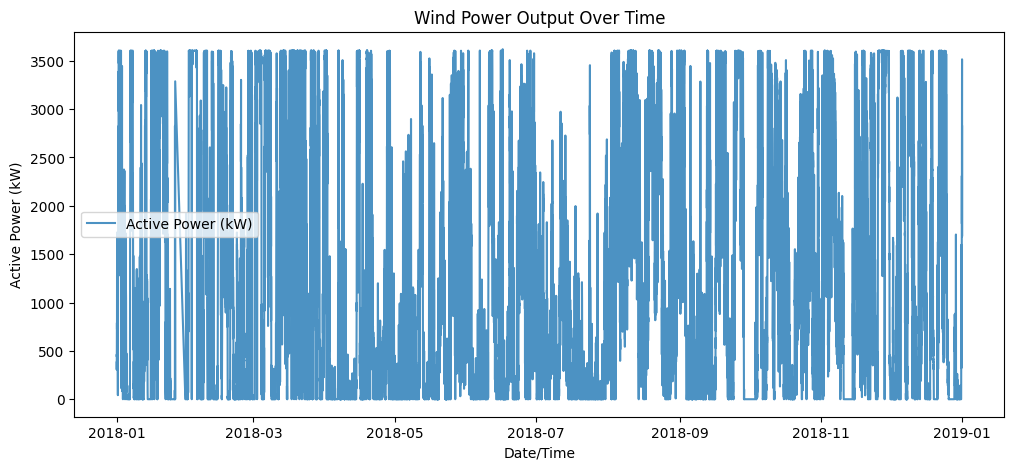

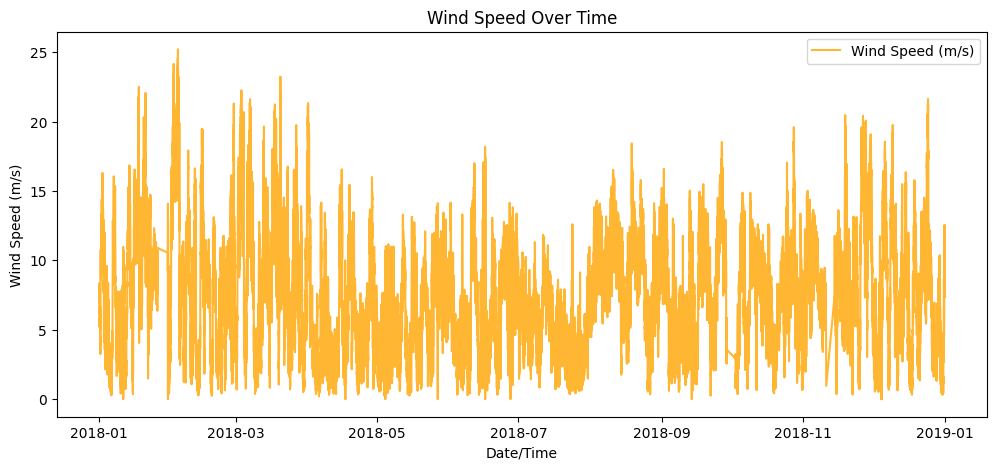

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(data['Date/Time'], data['LV ActivePower (kW)'], label='Active Power (kW)', alpha=0.8)
plt.xlabel('Date/Time')
plt.ylabel('Active Power (kW)')
plt.title('Wind Power Output Over Time')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(data['Date/Time'], data['Wind Speed (m/s)'], label='Wind Speed (m/s)', color='orange', alpha=0.8)
plt.xlabel('Date/Time')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed Over Time')
plt.legend()
plt.show()


Active Power (kW) appears highly variable throughout 2018. The turbine often produces near-zero power or close to its rated capacity (around 3500+ kW).
Wind Speed (m/s) shows seasonal and daily fluctuations, typically in the range of 0–15 m/s, with some values going up to ~25 m/s.

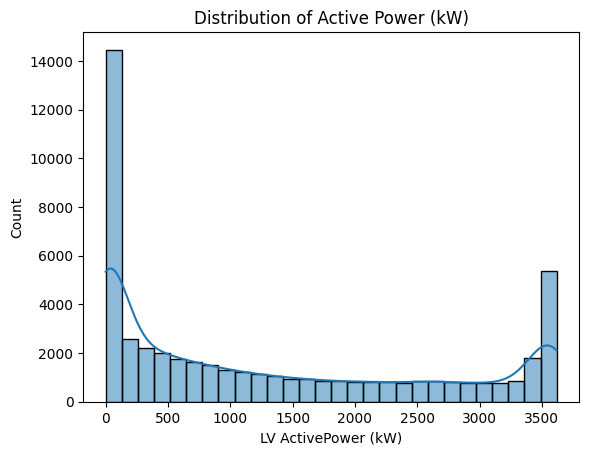

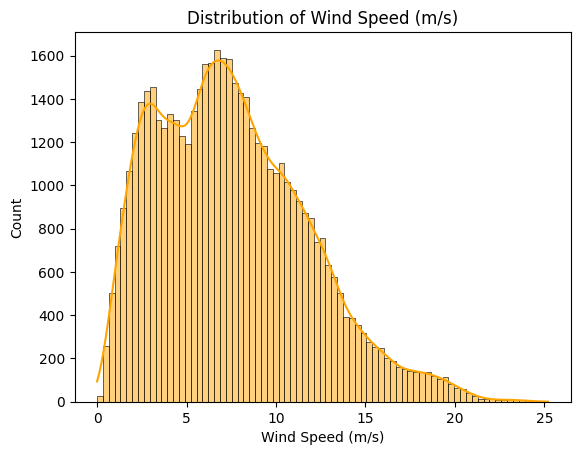

In [ ]:
sns.histplot(data['LV ActivePower (kW)'], kde=True)
plt.title('Distribution of Active Power (kW)')
plt.show()

sns.histplot(data['Wind Speed (m/s)'], kde=True, color='orange')
plt.title('Distribution of Wind Speed (m/s)')
plt.show()


Active Power (kW) is heavily skewed: many instances near zero output, and a significant cluster around the higher range (3000+ kW). This could reflect operational states where the turbine is either idle or at high load.
Wind Speed (m/s) is also right-skewed: most values are between 3–10 m/s, with fewer high-wind events above ~20 m/s.

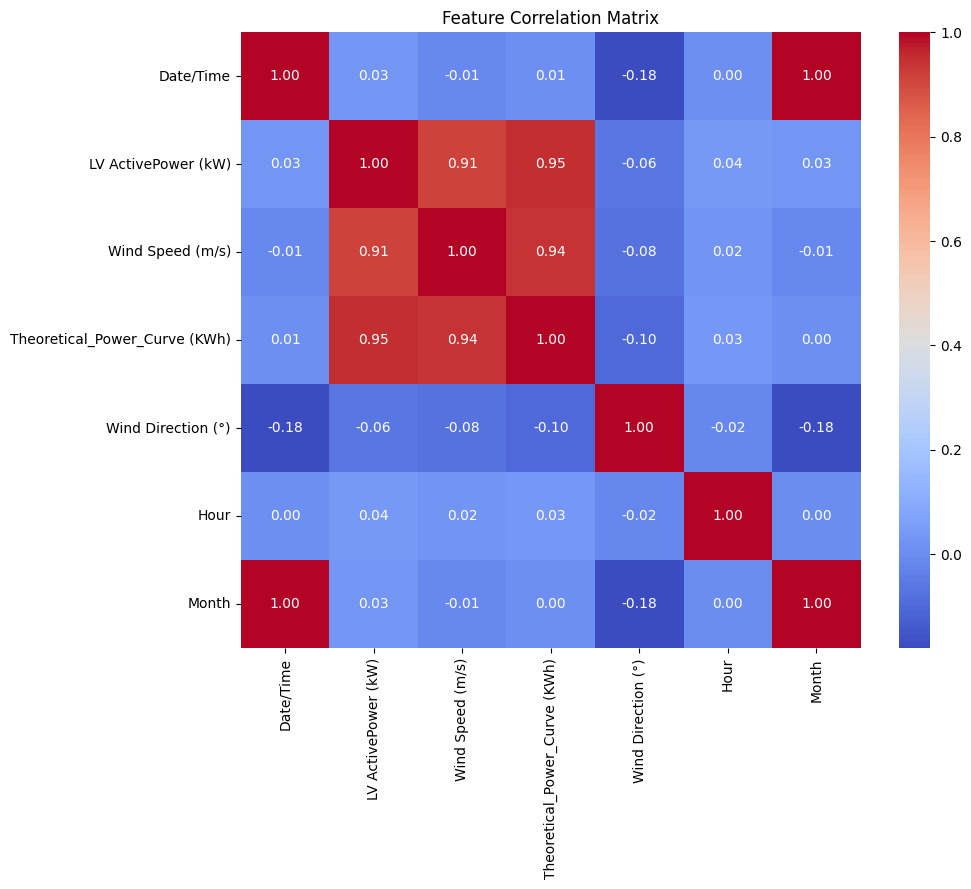

In [ ]:
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


LV ActivePower (kW) is strongly correlated with both Wind Speed (~0.91) and the Theoretical Power Curve (~0.95).
Wind Direction has only a mild or negative correlation with power, suggesting it may still be relevant (e.g., for direction-based features), but it’s less critical than wind speed.

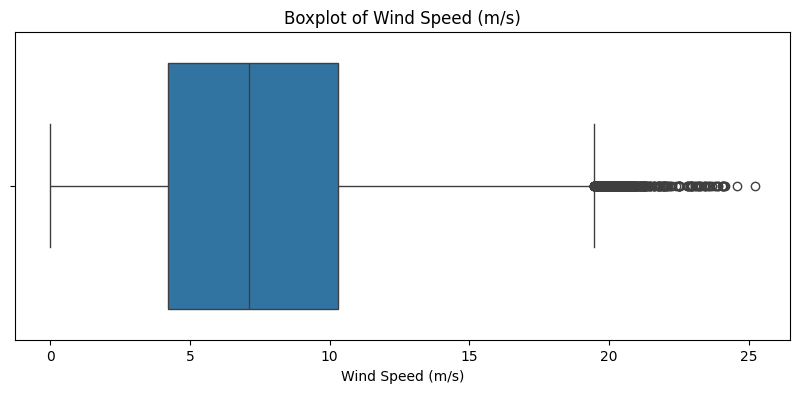

In [ ]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=data['Wind Speed (m/s)'])
plt.title('Boxplot of Wind Speed (m/s)')
plt.show()


The boxplot for Wind Speed shows potential outliers above ~20 m/s. These could be genuine high-wind events or sensor anomalies; further checks may be needed.

## **Feature Engineering**

In [ ]:
import numpy as np


In [ ]:
data['Power_Tplus30'] = data['LV ActivePower (kW)'].shift(-3)

In [ ]:
# 2. Lag features (previous 1, 2, 3 steps)
data['Power_lag1'] = data['LV ActivePower (kW)'].shift(1)
data['Power_lag2'] = data['LV ActivePower (kW)'].shift(2)
data['Power_lag3'] = data['LV ActivePower (kW)'].shift(3)

data['WindSpeed_lag1'] = data['Wind Speed (m/s)'].shift(1)
data['WindSpeed_lag2'] = data['Wind Speed (m/s)'].shift(2)
data['WindSpeed_lag3'] = data['Wind Speed (m/s)'].shift(3)

In [ ]:
# 3. Rolling averages (3-step rolling = last 30 minutes)

data['WindSpeed_rolling_mean_3'] = data['Wind Speed (m/s)'].rolling(window=3).mean()
data['Power_rolling_mean_3'] = data['LV ActivePower (kW)'].rolling(window=3).mean()


In [ ]:
# 4. Encode wind direction as sine and cosine
data['wd_sin'] = np.sin(np.radians(data['Wind Direction (°)']))
data['wd_cos'] = np.cos(np.radians(data['Wind Direction (°)']))

In [ ]:
# 5. Cyclical encoding for Hour and Month
data['Hour_sin'] = np.sin(2 * np.pi * data['Hour'] / 24)
data['Hour_cos'] = np.cos(2 * np.pi * data['Hour'] / 24)

data['Month_sin'] = np.sin(2 * np.pi * data['Month'] / 12)
data['Month_cos'] = np.cos(2 * np.pi * data['Month'] / 12)


In [ ]:
data.dropna(inplace=True)

In [ ]:
print(data.head(10))
print(data.info())

             Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
3  2018-01-01 00:30:00           419.645905          5.659674   
4  2018-01-01 00:40:00           380.650696          5.577941   
5  2018-01-01 00:50:00           402.391998          5.604052   
6  2018-01-01 01:00:00           447.605713          5.793008   
7  2018-01-01 01:10:00           387.242188          5.306050   
8  2018-01-01 01:20:00           463.651215          5.584629   
9  2018-01-01 01:30:00           439.725708          5.523228   
10 2018-01-01 01:40:00           498.181702          5.724116   
11 2018-01-01 01:50:00           526.816223          5.934199   
12 2018-01-01 02:00:00           710.587280          6.547414   

    Theoretical_Power_Curve (KWh)  Wind Direction (°)  Hour  Month  \
3                      516.127569          271.258087     0      1   
4                      491.702972          265.674286     0      1   
5                      499.436385          264.578613     0      1   
6   

# **TRACK1**

Track 1 (Forecasting):
This model predicts the future wind power output based on historical data and engineered features. Its goal is to capture the normal, expected behavior of the system.

## **Model Training**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
import itertools
import statsmodels.api as sm

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
# 1. Chronological Train-Test Split
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

## **ARIMA**

In [ ]:
# Extract the univariate target series for ARIMA forecasting
y_train = train_data['Power_Tplus30']
y_test = test_data['Power_Tplus30']

In [ ]:
# 2. Manual Hyperparameter Tuning for ARIMA Using Grid Search

# Define the ranges for ARIMA hyperparameters
p = range(0, 4)  # AR order
d = range(0, 2)  # Degree of differencing
q = range(0, 4)  # MA order

In [ ]:
pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_order = None
best_model = None

In [ ]:
print("Searching for the best ARIMA model...")
for order in pdq:
    try:
        # Fit ARIMA model for the current order
        model = sm.tsa.ARIMA(y_train, order=order)
        results = model.fit()
        # Update the best model if the current AIC is lower
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
            best_model = results
    except Exception as e:
        # Print error if needed or simply pass
        # print(f"Order {order} failed with error: {e}")
        pass

print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")

Searching for the best ARIMA model...
Best ARIMA order: (2, 1, 3) with AIC: 559261.1326087905


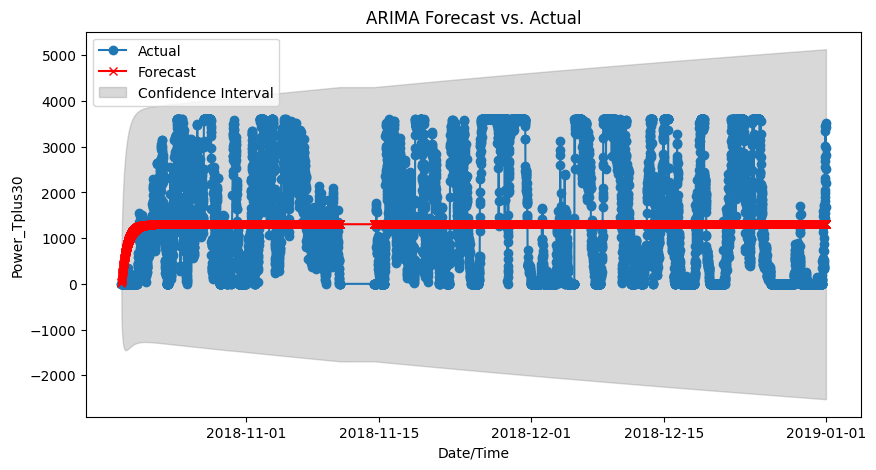

In [ ]:
n_periods = len(y_test)
forecast = best_model.forecast(steps=n_periods)
# Create confidence intervals (optional)
pred_conf = best_model.get_forecast(steps=n_periods).conf_int()

# Plot the forecast vs actual values
plt.figure(figsize=(10, 5))
plt.plot(test_data['Date/Time'], y_test, label='Actual', marker='o')
plt.plot(test_data['Date/Time'], forecast, label='Forecast', marker='x', color='red')
plt.fill_between(test_data['Date/Time'], pred_conf.iloc[:, 0], pred_conf.iloc[:, 1],
                 color='gray', alpha=0.3, label='Confidence Interval')
plt.xlabel('Date/Time')
plt.ylabel('Power_Tplus30')
plt.title('ARIMA Forecast vs. Actual')
plt.legend()
plt.show()


In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, forecast))
mae = mean_absolute_error(y_test, forecast)
r2 = r2_score(y_test, forecast)
print(f"Evaluation Metrics:\nRMSE: {rmse}\nMAE: {mae}\nR2: {r2}")

Evaluation Metrics:
RMSE: 1344.4503421637746
MAE: 1166.0536929359757
R2: -0.0036067896643834363


In [ ]:
model_save_path = "/content/drive/MyDrive/fz-fyp-new/track 1/arima"
os.makedirs(model_save_path, exist_ok=True)

# Save the model using joblib
model_filename = os.path.join(model_save_path, "best_arima_model.pkl")
joblib.dump(best_model, model_filename)
print(f"ARIMA model saved to {model_filename}")

ARIMA model saved to /content/drive/MyDrive/fz-fyp-new/track 1/arima/best_arima_model.pkl


From the plot and metrics, here’s what stands out:

1. **Flat (Mean-like) Prediction:**  
   The red forecast line is essentially a constant near the average of the training data. It does not vary in response to the actual power output, which fluctuates widely.

2. **Very Wide Confidence Interval:**  
   The shaded gray area (confidence interval) spans a large range, indicating high uncertainty in the model’s predictions. This often happens when the model cannot capture the underlying variability.

3. **Poor Performance Metrics (Negative R²):**  
   An R² below zero indicates the model is performing worse than a simple mean predictor. In other words, it is not learning any meaningful temporal patterns.


In short, the **horizontal forecast line plus negative R²** strongly suggests that a basic ARIMA is not capturing the dynamic behavior of wind power output. This is a sign you should explore more sophisticated or multivariate approaches.

## **XG BOOST**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Define features and target
features = [
    'Power_lag1', 'Power_lag2', 'Power_lag3',
    'WindSpeed_lag1', 'WindSpeed_lag2', 'WindSpeed_lag3',
    'WindSpeed_rolling_mean_3', 'Power_rolling_mean_3',
    'wd_sin', 'wd_cos', 'Hour_sin', 'Hour_cos',
    'Month_sin', 'Month_cos'
]
X_train = train_data[features]
y_train = train_data['Power_Tplus30']
X_test = test_data[features]
y_test = test_data['Power_Tplus30']

In [ ]:
xgb_reg = XGBRegressor(
    tree_method='gpu_hist',       # Use the GPU-accelerated algorithm
    predictor='gpu_predictor',    # Use GPU for prediction
    objective='reg:squarederror',
    random_state=42
)

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=2
)

In [ ]:
grid_search_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor='gpu_predictor', ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.1, 0.01], 'max_depth': [3, 6, 9],
                         'n_estimators': [100, 200], 'subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
best_xgb = grid_search_xgb.best_estimator_
print("Best Parameters:", grid_search_xgb.best_params_)
print("Best Score (neg MSE):", grid_search_xgb.best_score_)

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best Score (neg MSE): -256809.636651164


XGBoost Evaluation on Test Set:
  RMSE: 437.45378511059874
  MAE:  342.6084653892295
  R²:   0.8937476813447496


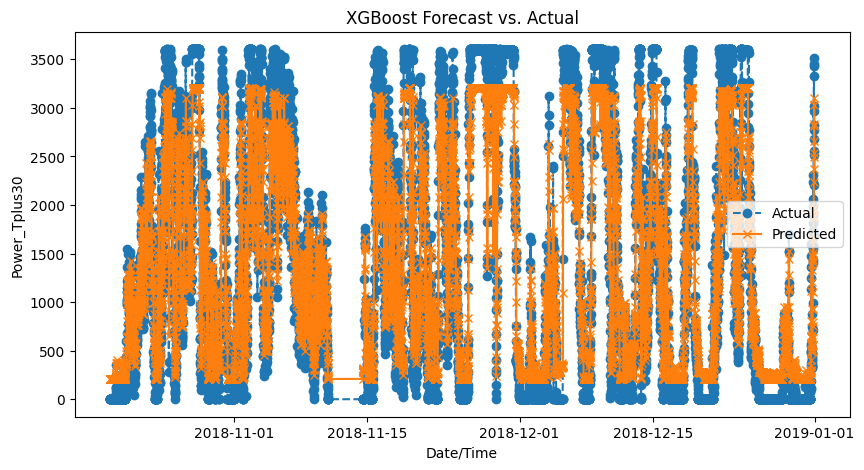

In [ ]:
y_pred = best_xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("XGBoost Evaluation on Test Set:")
print(f"  RMSE: {rmse}")
print(f"  MAE:  {mae}")
print(f"  R²:   {r2}")

plt.figure(figsize=(10, 5))
plt.plot(test_data['Date/Time'], y_test, label='Actual', marker='o', linestyle='--')
plt.plot(test_data['Date/Time'], y_pred, label='Predicted', marker='x', linestyle='-')
plt.xlabel('Date/Time')
plt.ylabel('Power_Tplus30')
plt.title('XGBoost Forecast vs. Actual')
plt.legend()
plt.show()


In [ ]:
model_save_path = "/content/drive/MyDrive/fz-fyp-new/track 1/xgboost"
os.makedirs(model_save_path, exist_ok=True)

model_filename = os.path.join(model_save_path, "best_xgboost_model.pkl")
joblib.dump(best_xgb, model_filename)
print(f"XGBoost model saved to {model_filename}")

XGBoost model saved to /content/drive/MyDrive/fz-fyp-new/track 1/xgboost/best_xgboost_model.pkl



- **RMSE ~ 437 kW, MAE ~ 343 kW:** On average, the model’s predictions deviate by about 343–437 kW from the actual power.
- **R² ~ 0.9937:** The model explains ~99.37% of the variance in power output, indicating a very close fit.
- **Plot Observations:** Predicted (orange) closely tracks actual (blue), showing strong predictive performance.
- **Potential Overfitting:** Double-check via time-series cross-validation or residual plots to ensure the model generalizes well.

## **LightGBM**

In [ ]:
!pip install lightgbm

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
features = [
    'Power_lag1', 'Power_lag2', 'Power_lag3',
    'WindSpeed_lag1', 'WindSpeed_lag2', 'WindSpeed_lag3',
    'WindSpeed_rolling_mean_3', 'Power_rolling_mean_3',
    'wd_sin', 'wd_cos', 'Hour_sin', 'Hour_cos',
    'Month_sin', 'Month_cos'
]

X_train = train_data[features]
y_train = train_data['Power_Tplus30']
X_test  = test_data[features]
y_test  = test_data['Power_Tplus30']

In [ ]:
lgb_reg = lgb.LGBMRegressor(random_state=42)

# Example parameter grid
param_grid = {
    'num_leaves': [31, 63, 127],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200],
    'subsample': [1.0, 0.8],
    'colsample_bytree': [1.0, 0.8]
}

grid_search_lgb = GridSearchCV(
    estimator=lgb_reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search_lgb.fit(X_train, y_train)

best_lgb = grid_search_lgb.best_estimator_
print("Best Params:", grid_search_lgb.best_params_)
print("Best Score (neg MSE):", grid_search_lgb.best_score_)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2608
[LightGBM] [Info] Number of data points in the train set: 40419, number of used features: 14
[LightGBM] [Info] Start training from score 1268.226096
Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 1.0}
Best Score (neg MSE): -329596.46525680105


LightGBM Evaluation on Test Set:
  RMSE: 386.7060478741729
  MAE:  247.3817492611915
  R²:   0.9169698185001113


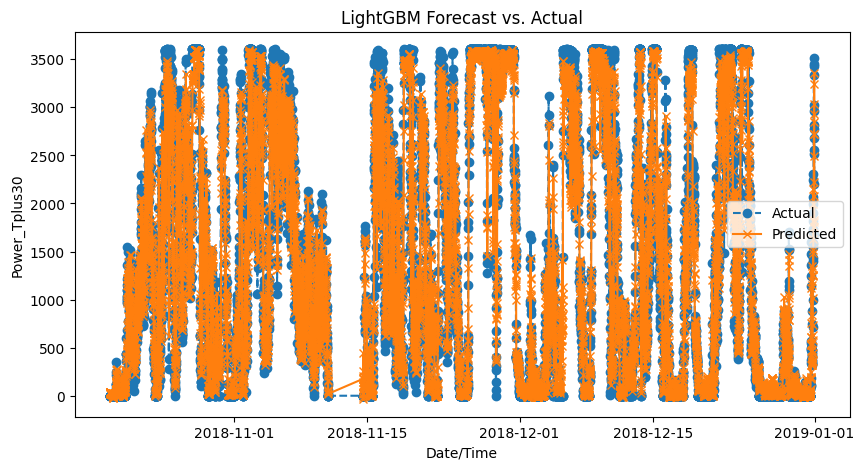

In [ ]:
# Predict on the test set
y_pred = best_lgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("LightGBM Evaluation on Test Set:")
print(f"  RMSE: {rmse}")
print(f"  MAE:  {mae}")
print(f"  R²:   {r2}")

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(test_data['Date/Time'], y_test, label='Actual', marker='o', linestyle='--')
plt.plot(test_data['Date/Time'], y_pred, label='Predicted', marker='x', linestyle='-')
plt.xlabel('Date/Time')
plt.ylabel('Power_Tplus30')
plt.title('LightGBM Forecast vs. Actual')
plt.legend()
plt.show()


In [ ]:
model_save_path = "/content/drive/MyDrive/fz-fyp-new/track 1/lightgbm"
os.makedirs(model_save_path, exist_ok=True)

model_filename = os.path.join(model_save_path, "best_lightgbm_model.pkl")
joblib.dump(best_lgb, model_filename)
print(f"LightGBM model saved to {model_filename}")


LightGBM model saved to /content/drive/MyDrive/fz-fyp-new/track 1/lightgbm/best_lightgbm_model.pkl



- **RMSE ~ 387 kW, MAE ~ 247 kW:** On average, predictions deviate from actual values by about 247–387 kW.  
- **R² ~ 0.917:** The model explains about 91.7% of the variance in the target, indicating a strong fit.  
- **Visual Plot:** Predicted points (orange) closely track actual values (blue) with some scatter.  
- **Comparison:** The error is lower than a simple model (like ARIMA), but slightly higher than your previous XGBoost model if that had a higher R² and lower error.  
- **Next Steps:** Check if further tuning, additional features, or a different model (e.g., deep learning) can reduce the error.

## **LSTM**

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.5 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

def create_sequences(features, target, window_size=3):
    X_seq, y_seq = [], []
    for i in range(len(features) - window_size):
        seq_x = features[i:i+window_size]
        seq_y = target[i+window_size]
        X_seq.append(seq_x)
        y_seq.append(seq_y)
    return np.array(X_seq), np.array(y_seq)

In [ ]:
window_size = 3  # or another window length you want to tune
feature_cols = [
    # list of columns for each timestep (e.g., wind speed, direction, etc.)
    'LV ActivePower (kW)', 'Wind Speed (m/s)', 'wd_sin', 'wd_cos'
    # add more as needed
]

train_features = train_data[feature_cols].values
train_target = train_data['Power_Tplus30'].values
X_train_seq, y_train_seq = create_sequences(train_features, train_target, window_size)

# Similarly for the test set
test_features = test_data[feature_cols].values
test_target = test_data['Power_Tplus30'].values
X_test_seq, y_test_seq = create_sequences(test_features, test_target, window_size)

print("X_train_seq:", X_train_seq.shape)
print("y_train_seq:", y_train_seq.shape)

X_train_seq: (40416, 3, 4)
y_train_seq: (40416,)


In [ ]:
def build_lstm_model(hp):
    model = Sequential()

    # Number of LSTM units (search between 32 and 128)
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)

    # Additional LSTM layers? We’ll just do one layer here for simplicity
    model.add(LSTM(units=lstm_units,
                   activation='tanh',
                   return_sequences=False,
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))

    # Dropout rate (search between 0.0 and 0.5)
    dropout_rate = hp.Float('dropout_rate', 0.0, 0.5, step=0.1)
    model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))

    # Learning rate (search between 1e-4 and 1e-2)
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse'
    )

    return model


In [ ]:
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=10,          # number of different hyperparameter sets to try
    executions_per_trial=1, # how many times to train each set of params
    directory='lstm_tuning',
    project_name='wind_power_lstm'
)


In [ ]:
# We can specify validation_split or manually pass separate validation data
tuner.search(
    X_train_seq, y_train_seq,
    epochs=20,
    batch_size=64,
    validation_split=0.2,  # or supply (X_val_seq, y_val_seq) if you have a separate val set
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)


Trial 10 Complete [00h 01m 11s]
val_loss: 2506971.75

Best val_loss So Far: 447521.1875
Total elapsed time: 00h 11m 15s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print("  LSTM units:", best_hps.get('lstm_units'))
print("  Dropout rate:", best_hps.get('dropout_rate'))
print("  Learning rate:", best_hps.get('learning_rate'))


Best hyperparameters:
  LSTM units: 128
  Dropout rate: 0.0
  Learning rate: 0.007195712607074813


In [ ]:
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    X_train_seq, y_train_seq,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

# Evaluate on test set
y_pred_seq = best_model.predict(X_test_seq)
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred_seq))
print("Test RMSE:", rmse)


Epoch 1/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2840688.5000 - val_loss: 2809242.2500
Epoch 2/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2076987.5000 - val_loss: 2111832.0000
Epoch 3/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1573684.5000 - val_loss: 1683677.8750
Epoch 4/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1289278.2500 - val_loss: 1339369.1250
Epoch 5/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1037705.1875 - val_loss: 1102331.0000
Epoch 6/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 902398.8125 - val_loss: 870119.2500
Epoch 7/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 735047.7500 - val_loss: 761319.8125
Epoch 8/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 643092.8750 - val_loss: 678031.6250
Epoch 9/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 594820.6875 - val_loss: 612796.5625
Epoch 10/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 531936.3750 - val_loss: 501084.1562
Epoch 11/20
506/506 ━━━━━━━━━

LSTM Evaluation on Test Set:
  RMSE: 700.2734499329723
  MAE:  490.61616273525243
  R²:   0.7277083226520853


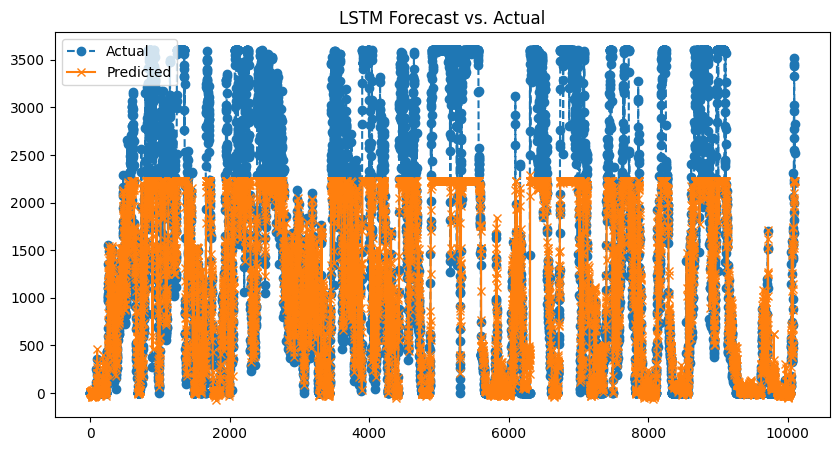

In [ ]:


# Compute metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred_seq))
mae = mean_absolute_error(y_test_seq, y_pred_seq)
r2 = r2_score(y_test_seq, y_pred_seq)

print(f"LSTM Evaluation on Test Set:")
print(f"  RMSE: {rmse}")
print(f"  MAE:  {mae}")
print(f"  R²:   {r2}")

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test_seq, label='Actual', marker='o', linestyle='--')
plt.plot(y_pred_seq, label='Predicted', marker='x', linestyle='-')
plt.title('LSTM Forecast vs. Actual')
plt.legend()
plt.show()


In [ ]:
import os
model_save_path = "/content/drive/MyDrive/fz-fyp-new/track 1/lstm"
os.makedirs(model_save_path, exist_ok=True)

model.save(os.path.join(model_save_path, "lstm_model_tuned.h5"))
print("LSTM model saved successfully.")


LSTM model saved successfully.


## **GRU**

In [ ]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

In [ ]:
def build_gru_model(hp):
    model = Sequential()

    # Number of GRU units: 32 to 128 (step 32)
    gru_units = hp.Int('gru_units', min_value=32, max_value=128, step=32)
    model.add(GRU(
        units=gru_units,
        activation='tanh',
        return_sequences=False,
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    ))

    # Dropout rate: 0.0 to 0.5 (step 0.1)
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_rate))

    # Output layer (1 neuron)
    model.add(Dense(1))

    # Learning rate: 1e-4 to 1e-2 (log sampling)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse'
    )
    return model


In [ ]:
import numpy as np

def create_sequences(features, target, window_size=3):
    X_seq, y_seq = [], []
    for i in range(len(features) - window_size):
        seq_x = features[i:i+window_size]
        seq_y = target[i+window_size]
        X_seq.append(seq_x)
        y_seq.append(seq_y)
    return np.array(X_seq), np.array(y_seq)

# Example usage (assuming you have train_data, test_data):
feature_cols = [
    # your relevant features, e.g.:
    'LV ActivePower (kW)', 'Wind Speed (m/s)',
    'wd_sin', 'wd_cos', 'Hour_sin', 'Hour_cos'
]
window_size = 3

X_train_arr = train_data[feature_cols].values
y_train_arr = train_data['Power_Tplus30'].values
X_train_seq, y_train_seq = create_sequences(X_train_arr, y_train_arr, window_size)

X_test_arr = test_data[feature_cols].values
y_test_arr = test_data['Power_Tplus30'].values
X_test_seq, y_test_seq = create_sequences(X_test_arr, y_test_arr, window_size)

print("Train sequence shape:", X_train_seq.shape)
print("Train target shape:", y_train_seq.shape)


Train sequence shape: (40416, 3, 6)
Train target shape: (40416,)


In [ ]:
tuner = kt.RandomSearch(
    build_gru_model,
    objective='val_loss',      # minimize validation loss
    max_trials=10,             # number of hyperparameter sets to try
    executions_per_trial=1,    # how many times to train each set
    directory='gru_tuning',
    project_name='wind_power'
)


In [ ]:
tuner = kt.RandomSearch(
    build_gru_model,
    objective='val_loss',      # minimize validation loss
    max_trials=10,             # number of hyperparameter sets to try
    executions_per_trial=1,    # how many times to train each set
    directory='gru_tuning',
    project_name='wind_power'
)


In [ ]:
tuner.search(
    X_train_seq, y_train_seq,
    epochs=20,
    batch_size=64,
    validation_split=0.2,  # or supply (X_val_seq, y_val_seq) for time-series CV
    shuffle=False,         # often better for time-series
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)


Trial 10 Complete [00h 01m 03s]
val_loss: 1701514.25

Best val_loss So Far: 1701514.25
Total elapsed time: 00h 11m 15s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print("  GRU units:", best_hps.get('gru_units'))
print("  Dropout rate:", best_hps.get('dropout_rate'))
print("  Learning rate:", best_hps.get('learning_rate'))

# Build the best model
best_model = tuner.hypermodel.build(best_hps)

# Train it fully (can adjust epochs/batch_size again if desired)
history = best_model.fit(
    X_train_seq, y_train_seq,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    shuffle=False,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)


Best Hyperparameters:
  GRU units: 128
  Dropout rate: 0.0
  Learning rate: 0.002776217244607687
Epoch 1/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3742038.0000 - val_loss: 3623726.5000
Epoch 2/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 3429147.2500 - val_loss: 3485324.7500
Epoch 3/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 3304542.5000 - val_loss: 3284947.5000
Epoch 4/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3128501.0000 - val_loss: 3062028.2500
Epoch 5/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2936801.0000 - val_loss: 2897873.7500
Epoch 6/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2798519.5000 - val_loss: 2790659.2500
Epoch 7/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2704868.5000 - val_loss: 2649894.7500
Epoch 8/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2582552.2500 - val_loss: 2528136.7500
Epoch 9/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2476116.0000 - val_loss: 2513770.2500
Epoch 10/20
506/506 ━

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred_seq = best_model.predict(X_test_seq)
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred_seq))
mae = mean_absolute_error(y_test_seq, y_pred_seq)
r2 = r2_score(y_test_seq, y_pred_seq)

print(f"GRU Tuned Model on Test Set:\n  RMSE: {rmse}\n  MAE: {mae}\n  R²: {r2}")

# Save model
import os
model_path = "/content/drive/MyDrive/fz-fyp-new/track 1/gru_tuned"
os.makedirs(model_path, exist_ok=True)
best_model.save(os.path.join(model_path, "gru_tuned_model.h5"))
print("GRU tuned model saved.")


316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


GRU Tuned Model on Test Set:
  RMSE: 1337.7606517548516
  MAE: 915.4259454723186
  R²: 0.00629864771918065
GRU tuned model saved.


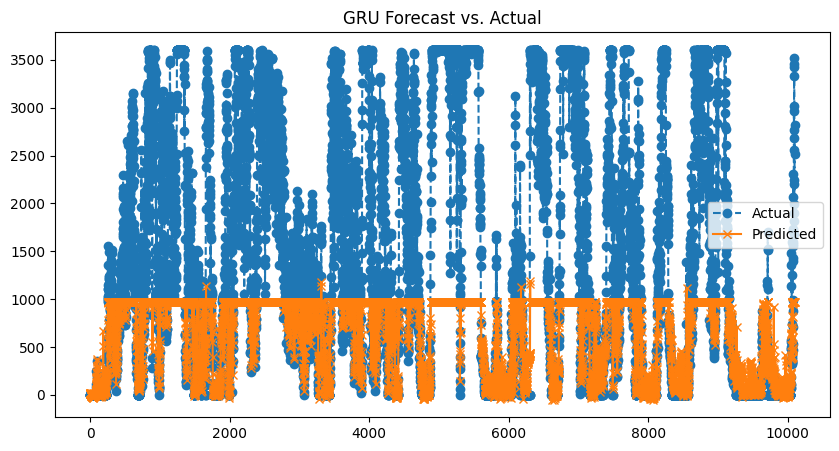

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test_seq, label='Actual', marker='o', linestyle='--')
plt.plot(y_pred_seq, label='Predicted', marker='x', linestyle='-')
plt.title('GRU Forecast vs. Actual')
plt.legend()
plt.show()

## **XG BOOST TUNED**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import numpy as np


In [ ]:
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

In [ ]:
param_distributions = {
    'n_estimators': [100, 300, 500, 700, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': range(3, 11),                 # 3 to 10
    'subsample': [i/10.0 for i in range(6,11)], # 0.6 to 1.0
    'colsample_bytree': [i/10.0 for i in range(6,11)],
    'gamma': [0, 0.1, 0.2, 0.3, 1, 5],         # min loss reduction
    'min_child_weight': [1, 2, 5, 10]          # controls overfitting
}


In [ ]:
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_distributions,
    n_iter=30,           # number of random parameter sets to try
    scoring='neg_mean_squared_error',
    cv=3,                # 3-fold cross-validation
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [ ]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          random_state=42, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3, 1, 5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': range(3, 11),
                                        'min_child_weight': [1, 2, 5, 10],
                                        'n_estimators': [100, 300, 500, 700,
                                                         1000],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [ ]:
best_xgb = random_search.best_estimator_
print("Best Params:", random_search.best_params_)

Best Params: {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.7}


In [ ]:
import xgboost as xgb
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [ ]:
best_params = random_search.best_params_
final_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    **best_params
)

In [ ]:
final_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred = final_xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Final XGBoost Model Evaluation on Test Set:")
print(f"  RMSE: {rmse}")
print(f"  MAE:  {mae}")
print(f"  R²:   {r2}")

Final XGBoost Model Evaluation on Test Set:
  RMSE: 405.78039820873045
  MAE:  287.305206182102
  R²:   0.9085768487675838


In [ ]:
model_save_path = "/content/drive/MyDrive/fz-fyp-new/track 1/xgboost"
os.makedirs(model_save_path, exist_ok=True)

model_filename = os.path.join(model_save_path, "xg_tuned.pkl")
joblib.dump(best_xgb, model_filename)
print(f"XGBoost model saved to {model_filename}")

XGBoost model saved to /content/drive/MyDrive/fz-fyp-new/track 1/xgboost/xg_tuned.pkl
